In [27]:
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import datetime
import calendar
import time
import matplotlib.pyplot as plt
import math

#from sklearn import linear_model
#from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn import linear_model
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier

# scaling the input feature
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

from joblib import load
from joblib import dump

In [2]:
df_train = pd.read_csv('crime_data/fullTrainTestCrimeData_train_weather_by_hourgroup_police_rand_2019_06_27.csv')
df_train = df_train.drop(columns=["Unnamed: 0"])

#df_train.boxplot(column="Value")
# remove outliers
ind_to_drop_outlier = df_train[df_train["Value"]>60].index
df_train = df_train.drop(ind_to_drop_outlier, axis=0)

df_valid = pd.read_csv('crime_data/fullTrainTestCrimeData_valid_weather_by_hourgroup_police_rand_2019_06_27.csv')
df_valid = df_valid.drop(columns=["Unnamed: 0"])

df_test = pd.read_csv('crime_data/fullTrainTestCrimeData_tests_weather_by_hourgroup_police_rand_2019_06_27.csv')
df_test = df_test.drop(columns=["Unnamed: 0"])

#df_uniq_id["DATE"] = df_uniq_id["OCCURRED_ON_DATE"].apply(lambda x: x.split(" ")[0])
df_train["Value_Occ"] = df_train["Value"].apply(lambda x: 1 if x>0 else x)
df_valid["Value_Occ"] = df_valid["Value"].apply(lambda x: 1 if x>0 else x)
df_test["Value_Occ"]  = df_test["Value"].apply(lambda x: 1 if x>0 else x)

In [3]:
x_train = df_train[["Hour_Grp","DAY_OF_MONTH","DAY_OF_WEEK_NUM","MONTH","Lat","Long"
                    ,"Temperature(F)","Humidity(%)","Wind Speed(mph)","Precip.(in)",
                    "closest_police_d","closest_mbta_d"]]

x_valid = df_valid[["Hour_Grp","DAY_OF_MONTH","DAY_OF_WEEK_NUM","MONTH","Lat","Long"
                    ,"Temperature(F)","Humidity(%)","Wind Speed(mph)","Precip.(in)",
                    "closest_police_d","closest_mbta_d"]]

x_test = df_test[["Hour_Grp","DAY_OF_MONTH","DAY_OF_WEEK_NUM","MONTH","Lat","Long"
                    ,"Temperature(F)","Humidity(%)","Wind Speed(mph)","Precip.(in)",
                  "closest_police_d","closest_mbta_d"]]

y_train = df_train[["Value_Occ"]]
y_valid = df_valid[["Value_Occ"]]
y_test = df_test[["Value_Occ"]]

In [4]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [5]:
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(x_train, y_train)
x_train_resampled = pd.DataFrame(X_resampled, columns =["Hour_Grp","DAY_OF_MONTH","DAY_OF_WEEK_NUM","MONTH","Lat","Long"
                    ,"Temperature(F)","Humidity(%)","Wind Speed(mph)","Precip.(in)",
                  "closest_police_d","closest_mbta_d"]) 

### Variable String for scaling

In [6]:
var_scale_strs = ["Lat","Long",
                  "Temperature(F)","Humidity(%)","Wind Speed(mph)","Precip.(in)",
                  "closest_police_d","closest_mbta_d"]

## Grad Boosted DT
- #### Load model 
- #### or Run training

In [7]:
params = {
    'n_estimators': 100,
    'max_depth': 6,
    'learning_rate': 0.1,
    'criterion': 'friedman_mse',
    'random_state': 42
}


ct = ColumnTransformer([
        ('somename', StandardScaler(), var_scale_strs)
    ], remainder='passthrough')

grad_boost_classi_pipe = Pipeline(steps=[('preprocessor', ct),
                      ('classifier', ensemble.GradientBoostingClassifier(**params))])

grad_boost_classi_pipe.fit(x_train_resampled, y_resampled)

/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('somename',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                                                                 with_std=True),
                                                  ['Lat', 'Long',
                                                   'Temperature(F)',
                                                   'Humidity(%)',
                                                   'Wind Speed(mph)',
                                                   'Precip.(in)',
                                                   'closest_police_d',
                                              

In [8]:
predictions_test = grad_boost_classi_pipe.predict(x_test)
print ("test f1 ", f1_score(y_test, predictions_test))
print ("test accuracy_score ", accuracy_score(y_test, predictions_test))

test f1  0.5827133501361432
test accuracy_score  0.7498604436677831


In [18]:
# predictions_valid = grad_boost_classi_pipe.predict(x_valid)
# print ("validate f1 ", f1_score(y_valid, predictions_valid))
# print ("validate accuracy_score ", accuracy_score(y_valid, predictions_valid))

# predictions_train = grad_boost_classi_pipe.predict(x_train)
# print ("train f1 ", f1_score(y_train, predictions_train))
# print ("train accuracy_score ", accuracy_score(y_train, predictions_train))

### Save Model

In [41]:
# save model
# https://www.mikulskibartosz.name/how-to-save-a-machine-learning-model-into-a-file/
toBePersisted = dict({
    'model': grad_boost_classi_pipe,
    'metadata': {
        'name': 'Does a crime occur?',
        'author': 'Apichart H',
        
    }
})

dump(toBePersisted, 'grad_bdt_classi_police_mbta_rand_undersampling.joblib')

['grad_bdt_classi_police_mbta_rand_undersampling.joblib']

### Features importance

In [51]:
f_important = grad_boost_classi_pipe["classifier"].feature_importances_
print(grad_boost_classi_pipe["classifier"].feature_importances_)

fea = ["Lat","Long","Temperature(F)","Humidity(%)","Wind Speed(mph)","Precip.(in)",
 "closest_police_d","closest_mbta_d","Hour_Grp","DAY_OF_MONTH","DAY_OF_WEEK_NUM","MONTH"]

[0.0973986  0.32934314 0.01002314 0.00497763 0.00464153 0.00100501
 0.34549193 0.09484293 0.10049711 0.00385785 0.00601457 0.00190656]


RangeIndex(start=0, stop=1, step=1)


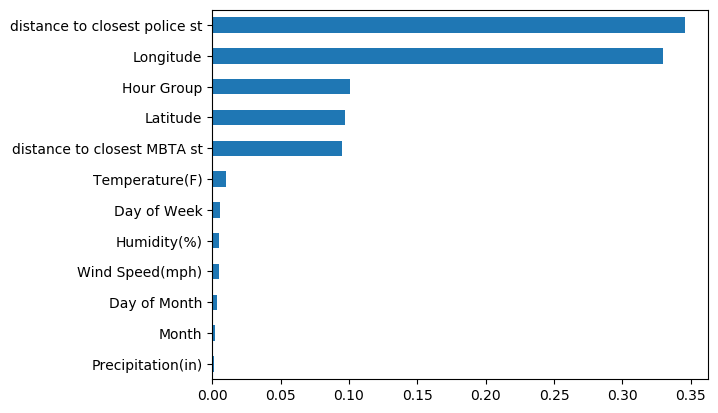

In [52]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

objects = ("Latitude","Longitude","Temperature(F)","Humidity(%)","Wind Speed(mph)","Precipitation(in)",
 "distance to closest police st","distance to closest MBTA st","Hour Group","Day of Month","Day of Week","Month")

## create df of feature important to make plotting easy
data= []
dat ={}
for i in range(len(objects)):
    dat[objects[i]] =  f_important[i]
data +=[dat]

df_imp = pd.DataFrame(data)
df_imp = df_imp.transpose()
print (df_imp.columns)
df_imp = df_imp.sort_values(by=0, axis=0, ascending=True)
df_imp

# make plot
df_imp.plot(kind='barh',legend=False)

## Logistic Regression (WITH imbalance treatment)

In [11]:
##------------------------------
##  Logistic regression
##  using >1 features
##------------------------------

ct1 = ColumnTransformer([
        ('somename', StandardScaler(), var_scale_strs)
    ], remainder='passthrough')

logistic_pipe = Pipeline(steps=[('preprocessor', ct1),
                                ('classifier', linear_model.LogisticRegression())])

logistic_pipe.fit(x_train_resampled, y_resampled)

/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('somename',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                                                                 with_std=True),
                                                  ['Lat', 'Long',
                                                   'Temperature(F)',
                                                   'Humidity(%)',
                                                   'Wind Speed(mph)',
                                                   'Precip.(in)',
                                                   'closest_police_d',
                                              

In [12]:
predictions_logis_test = logistic_pipe.predict(x_test)
print ("logist Test accuracy ",accuracy_score(y_test, predictions_logis_test))
print ("logist Test f1_score ",f1_score(y_test, predictions_logis_test))

logist Test accuracy  0.6516006504538615
logist Test f1_score  0.5074247870360045


In [13]:
print("Classification Report logis")
print(classification_report(y_test, predictions_logis_test))

Classification Report logis
              precision    recall  f1-score   support

           0       0.89      0.62      0.73    125556
           1       0.38      0.75      0.51     39252

    accuracy                           0.65    164808
   macro avg       0.64      0.69      0.62    164808
weighted avg       0.77      0.65      0.68    164808



In [14]:
print("Classification Report GradBoost")
print(classification_report(y_test, predictions_test))

Classification Report GradBoost
              precision    recall  f1-score   support

           0       0.90      0.76      0.82    125556
           1       0.48      0.73      0.58     39252

    accuracy                           0.75    164808
   macro avg       0.69      0.74      0.70    164808
weighted avg       0.80      0.75      0.76    164808



### DummyClassifier
- constant (0 or 1)

In [23]:
dummy = DummyClassifier(strategy='constant',constant=0)
dummy.fit(x_train, y_train)
dum_predics = dummy.predict(x_test)
print("Dummy Confusion Matrix:")
print(confusion_matrix(y_test, dum_predics))
print()
# print("Dummy Classification Report")
# print(classification_report(y_valid, dum_predics))
print ("all 0 Test accuracy ",accuracy_score(y_test, dum_predics))
#print ("all 0 Test f1_score ",f1_score(y_test, dum_predics))
#print("Classification Report All 0")
#print(classification_report(y_test, dum_predics))

Dummy Confusion Matrix:
[[125556      0]
 [ 39252      0]]

all 0 Test accuracy  0.7618319499053444


In [25]:
dummy = DummyClassifier(strategy='constant',constant=1)
dummy.fit(x_train, y_train)
dum_predics = dummy.predict(x_test)
print("Dummy Confusion Matrix:")
print(confusion_matrix(y_test, dum_predics))
print()
# print("Dummy Classification Report")
# print(classification_report(y_valid, dum_predics))
print ("all 1 Test accuracy ",accuracy_score(y_test, dum_predics))
print ("all 1 Test f1_score ",f1_score(y_test, dum_predics))
# print("Classification Report All 1")
# print(classification_report(y_test, dum_predics))

Dummy Confusion Matrix:
[[     0 125556]
 [     0  39252]]

all 1 Test accuracy  0.2381680500946556
all 1 Test f1_score  0.3847103793002058


## Load Model and evaluate 
- ##### This is how you build a df for an input

In [26]:
loaded_model = load('grad_bdt_classi_police_mbta_rand_undersampling_2019_06_28_F1p583_pipe.joblib')
loaded_model

{'model': Pipeline(memory=None,
          steps=[('preprocessor',
                  ColumnTransformer(n_jobs=None, remainder='passthrough',
                                    sparse_threshold=0.3,
                                    transformer_weights=None,
                                    transformers=[('somename',
                                                   StandardScaler(copy=True,
                                                                  with_mean=True,
                                                                  with_std=True),
                                                   ['Lat', 'Long',
                                                    'Temperature(F)',
                                                    'Humidity(%)',
                                                    'Wind Speed(mph)',
                                                    'Precip.(in)',
                                                    'closest_police_d',
                      

In [68]:
# to test it, I need an input that I know the prediction value
a = pd.DataFrame({'col1':predictions_test})
#a[a["col1"] == 1]
a.loc[4579].col1

1

In [69]:
# Get feature of this exapmle
x_test4_tmp = df_test.loc[4579]
x_test4_tmp.DAY_OF_MONTH

1

In [76]:
data = {'Hour_Grp':[x_test4_tmp.Hour_Grp],
        'DAY_OF_MONTH':[x_test4_tmp.DAY_OF_MONTH], 
        'DAY_OF_WEEK_NUM':[x_test4_tmp.DAY_OF_WEEK_NUM], 
        'MONTH':[x_test4_tmp.MONTH], 
       'Lat':[x_test4_tmp.Lat],
       'Long':[x_test4_tmp.Long],
       'Temperature(F)':[x_test4_tmp["Temperature(F)"]],
       'Humidity(%)':[x_test4_tmp["Humidity(%)"]],
       'Wind Speed(mph)':[x_test4_tmp["Wind Speed(mph)"]],
       'Precip.(in)':[x_test4_tmp["Precip.(in)"]],
       'closest_police_d': [x_test4_tmp.closest_police_d],
       'closest_mbta_d': [x_test4_tmp.closest_mbta_d],
       }  
# Create DataFrame 
x_test4 = pd.DataFrame(data)
x_test4

,Hour_Grp,DAY_OF_MONTH,DAY_OF_WEEK_NUM,MONTH,Temperature(F),Humidity(%),Wind Speed(mph),Precip.(in),closest_police_d,closest_mbta_d,Lat,Long
0,2,1,4,11,56.166667,84.083333,7.333333,0.0,0.493969,2.458019,42.2494,-71.1232


In [77]:
predictions = loaded_model["model"].predict(x_test4)
predictions

array([1])

In [78]:
data = {'Hour_Grp':[3],
        'DAY_OF_MONTH':[1], 
        'DAY_OF_WEEK_NUM':[7], 
        'MONTH':[4], 
       'Lat':[42.35565],
       'Long':[-71.17145],
       'Temperature(F)':[47.791667],
       'Humidity(%)':[43.75],
       'Wind Speed(mph)':[18.125],
       'Precip.(in)':[0.0],
       'closest_police_d': [2],
       'closest_mbta_d': [4],
       }  
# Create DataFrame 
x_test3 = pd.DataFrame(data) 

In [79]:
predictions = loaded_model["model"].predict(x_test3)
predictions

array([0])

## Tuning parameters for GradBoost

In [34]:
## Tuning

learning_rates = [0.01, 0.02, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4]
for l_rate in learning_rates:
    params = {
    'n_estimators': 100,
    'max_depth': 6,
    'learning_rate': l_rate,
    'criterion': 'friedman_mse',
    'random_state': 42
    }
    
    ct = ColumnTransformer([
        ('somename', StandardScaler(), 
         ["Lat","Long","Temperature(F)","Humidity(%)","Wind Speed(mph)","Precip.(in)","closest_police_d","closest_mbta_d"])
    ], remainder='passthrough')

    gb = Pipeline(steps=[('preprocessor', ct),
                      ('classifier', ensemble.GradientBoostingClassifier(**params))])


    gb.fit(x_train_resampled, y_resampled)
    predictions_valid = gb.predict(x_valid)
    predictions_train = gb.predict(x_train_resampled)
    print("learning_rate: ", l_rate)
    print("Accuracy score (training): {0:.3f}".format(accuracy_score(y_resampled, predictions_train)))
    print("Accuracy score (validation): {0:.3f}".format(accuracy_score(y_valid, predictions_valid)))
    print("F1 score (training): {0:.3f}".format(f1_score(y_resampled, predictions_train)))
    print("F1 score (validation): {0:.3f}".format(f1_score(y_valid, predictions_valid)))
    y_scores_gb = gb.decision_function(x_valid)
    fpr_gb, tpr_gb, _ = roc_curve(y_valid, y_scores_gb)
    roc_auc_gb = auc(fpr_gb, tpr_gb)
    print("roc_auc  (validation): {0:.3f}".format(roc_auc_gb))
    
    print()
    

/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


learning_rate:  0.01
Accuracy score (training): 0.744
Accuracy score (validation): 0.725
F1 score (training): 0.754
F1 score (validation): 0.597
roc_auc  (validation): 0.819



/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


learning_rate:  0.02
Accuracy score (training): 0.749
Accuracy score (validation): 0.740
F1 score (training): 0.756
F1 score (validation): 0.608
roc_auc  (validation): 0.830



/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


learning_rate:  0.05
Accuracy score (training): 0.755
Accuracy score (validation): 0.742
F1 score (training): 0.760
F1 score (validation): 0.613
roc_auc  (validation): 0.835



/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


learning_rate:  0.1
Accuracy score (training): 0.759
Accuracy score (validation): 0.744
F1 score (training): 0.763
F1 score (validation): 0.614
roc_auc  (validation): 0.836



/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


learning_rate:  0.15
Accuracy score (training): 0.762
Accuracy score (validation): 0.742
F1 score (training): 0.767
F1 score (validation): 0.610
roc_auc  (validation): 0.834



/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


learning_rate:  0.2
Accuracy score (training): 0.766
Accuracy score (validation): 0.738
F1 score (training): 0.770
F1 score (validation): 0.609
roc_auc  (validation): 0.834



/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


learning_rate:  0.25
Accuracy score (training): 0.769
Accuracy score (validation): 0.740
F1 score (training): 0.773
F1 score (validation): 0.610
roc_auc  (validation): 0.833



/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


learning_rate:  0.3
Accuracy score (training): 0.771
Accuracy score (validation): 0.738
F1 score (training): 0.774
F1 score (validation): 0.605
roc_auc  (validation): 0.832



/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


learning_rate:  0.4
Accuracy score (training): 0.775
Accuracy score (validation): 0.736
F1 score (training): 0.780
F1 score (validation): 0.602
roc_auc  (validation): 0.827



In [35]:
## Tuning
depths = [4, 5, 6, 7, 8]
for depth in depths:
    params = {
    'n_estimators': 100,
    'max_depth': depth,
    'learning_rate': 0.1,
    'criterion': 'friedman_mse',
    'random_state': 42
    }
    
    ct = ColumnTransformer([
        ('somename', StandardScaler(), 
         ["Lat","Long","Temperature(F)","Humidity(%)","Wind Speed(mph)","Precip.(in)","closest_police_d","closest_mbta_d"])
    ], remainder='passthrough')

    gb = Pipeline(steps=[('preprocessor', ct),
                      ('classifier', ensemble.GradientBoostingClassifier(**params))])

    
    gb.fit(x_train_resampled, y_resampled)
    predictions_valid = gb.predict(x_valid)
    predictions_train = gb.predict(x_train_resampled)
    print("max_depth: ", depth)
    print("Accuracy score (training): {0:.3f}".format(accuracy_score(y_resampled, predictions_train)))
    print("Accuracy score (validation): {0:.3f}".format(accuracy_score(y_valid, predictions_valid)))
    print("F1 score (training): {0:.3f}".format(f1_score(y_resampled, predictions_train)))
    print("F1 score (validation): {0:.3f}".format(f1_score(y_valid, predictions_valid)))
    y_scores_gb = gb.decision_function(x_valid)
    fpr_gb, tpr_gb, _ = roc_curve(y_valid, y_scores_gb)
    roc_auc_gb = auc(fpr_gb, tpr_gb)
    print("roc_auc  (validation): {0:.3f}".format(roc_auc_gb))
    
    print()

/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


max_depth:  4
Accuracy score (training): 0.752
Accuracy score (validation): 0.733
F1 score (training): 0.755
F1 score (validation): 0.603
roc_auc  (validation): 0.832



/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


max_depth:  5
Accuracy score (training): 0.756
Accuracy score (validation): 0.739
F1 score (training): 0.760
F1 score (validation): 0.610
roc_auc  (validation): 0.833



/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


max_depth:  6
Accuracy score (training): 0.759
Accuracy score (validation): 0.744
F1 score (training): 0.763
F1 score (validation): 0.614
roc_auc  (validation): 0.836



/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


max_depth:  7
Accuracy score (training): 0.766
Accuracy score (validation): 0.743
F1 score (training): 0.770
F1 score (validation): 0.612
roc_auc  (validation): 0.835



/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


max_depth:  8
Accuracy score (training): 0.773
Accuracy score (validation): 0.742
F1 score (training): 0.778
F1 score (validation): 0.612
roc_auc  (validation): 0.833



In [36]:
## Tuning
ns_estimators = [50,100,150,200, 300, 400]
for nest in ns_estimators:
    params = {
    'n_estimators': nest,
    'max_depth': 6,
    'learning_rate': 0.1,
    'criterion': 'friedman_mse',
    'random_state': 42
    }
    
    ct = ColumnTransformer([
        ('somename', StandardScaler(), 
         ["Lat","Long","Temperature(F)","Humidity(%)","Wind Speed(mph)","Precip.(in)","closest_police_d","closest_mbta_d"])
    ], remainder='passthrough')

    gb = Pipeline(steps=[('preprocessor', ct),
                      ('classifier', ensemble.GradientBoostingClassifier(**params))])
    
    gb.fit(x_train_resampled, y_resampled)
    predictions_valid = gb.predict(x_valid)
    predictions_train = gb.predict(x_train_resampled)
    print("n_estimator: ", nest)
    print("Accuracy score (training): {0:.3f}".format(accuracy_score(y_resampled, predictions_train)))
    print("Accuracy score (validation): {0:.3f}".format(accuracy_score(y_valid, predictions_valid)))
    print("F1 score (training): {0:.3f}".format(f1_score(y_resampled, predictions_train)))
    print("F1 score (validation): {0:.3f}".format(f1_score(y_valid, predictions_valid)))
    y_scores_gb = gb.decision_function(x_valid)
    fpr_gb, tpr_gb, _ = roc_curve(y_valid, y_scores_gb)
    roc_auc_gb = auc(fpr_gb, tpr_gb)
    print("roc_auc  (validation): {0:.3f}".format(roc_auc_gb))
    
    print()

/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


n_estimator:  50
Accuracy score (training): 0.755
Accuracy score (validation): 0.745
F1 score (training): 0.759
F1 score (validation): 0.614
roc_auc  (validation): 0.835



/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


n_estimator:  100
Accuracy score (training): 0.759
Accuracy score (validation): 0.744
F1 score (training): 0.763
F1 score (validation): 0.614
roc_auc  (validation): 0.836



/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


n_estimator:  150
Accuracy score (training): 0.763
Accuracy score (validation): 0.743
F1 score (training): 0.766
F1 score (validation): 0.613
roc_auc  (validation): 0.836



/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


n_estimator:  200
Accuracy score (training): 0.766
Accuracy score (validation): 0.742
F1 score (training): 0.769
F1 score (validation): 0.612
roc_auc  (validation): 0.836



/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


n_estimator:  300
Accuracy score (training): 0.771
Accuracy score (validation): 0.741
F1 score (training): 0.775
F1 score (validation): 0.610
roc_auc  (validation): 0.834



/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


n_estimator:  400
Accuracy score (training): 0.775
Accuracy score (validation): 0.740
F1 score (training): 0.779
F1 score (validation): 0.609
roc_auc  (validation): 0.833



/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


n_estimator:  600
Accuracy score (training): 0.784
Accuracy score (validation): 0.739
F1 score (training): 0.788
F1 score (validation): 0.608
roc_auc  (validation): 0.832

